# Mini-Project 2 - Classification
The following mini-project is focused on sharpening your Data Science skills in the context of
Classification!

## Q1: Comparing Classification Models ##


In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Q1b
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # Q1c
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression # Q1b
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


#### a. Please use the scikit-learn breast cancer dataset (e.g with the Python sklearn.datasets.load_breast_cancer() command), and perform a randomized (80%/20%) train/test split of the data to allow for model cross-validation in later steps.)

In [43]:
import seaborn as sns
from sklearn.datasets import load_breast_cancer

# Load the dataset from sklearn
bcancer = load_breast_cancer()
X = bcancer.data
y = bcancer.target
feature_names = bcancer.feature_names

# Create a Pandas DataFrame 
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Divide into training set and test set (Code from Precept 7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define training data
train_data = pd.DataFrame(X_train, columns=feature_names)
train_data['target'] = y_train

# Define testing data
test_data = pd.DataFrame(X_test, columns=feature_names)
test_data['target'] = y_test




#### b. Please perform an exploratory data analysis on your training set to gain intuition for your modelling efforts. Do you notice anything interesting? Which features seem most important? Why?

I conducted multivariate graphical analysis because there are over 30 features, and I believed this visualization of features in relationship to each other and the cancer classification would best contextualize the dataset. When plotting each feature against the target variable, which is 0 if the tumor is malignant and 1 if the tumor is benign, I found that the mean radius, perimeter, area, and texture of malignant tumors tended to be larger. Alternatively, mean symmetry and mean smoothness were less distinguishable, having a wider range of values for both benign and malignant tumors. The mean radius, mean perimeter, and mean area seem the most important seemed the most important, not only because the distinction between malignant and benign seemed most apparent, but when plotting the features against each other, those three features had almost a perfectly linear relationship.

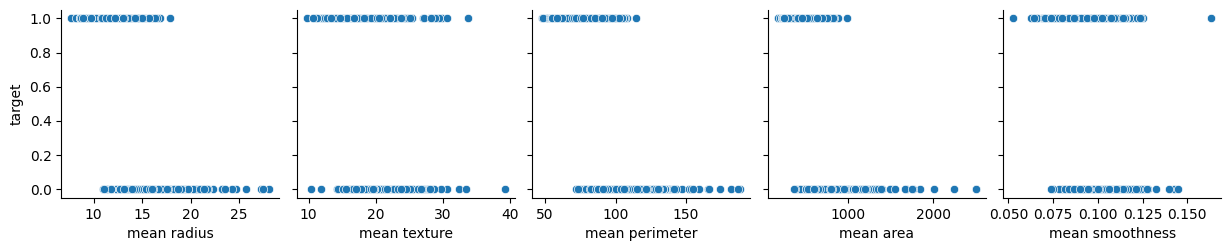

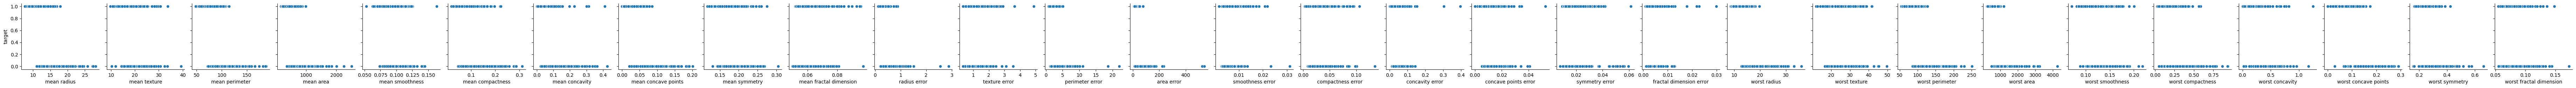

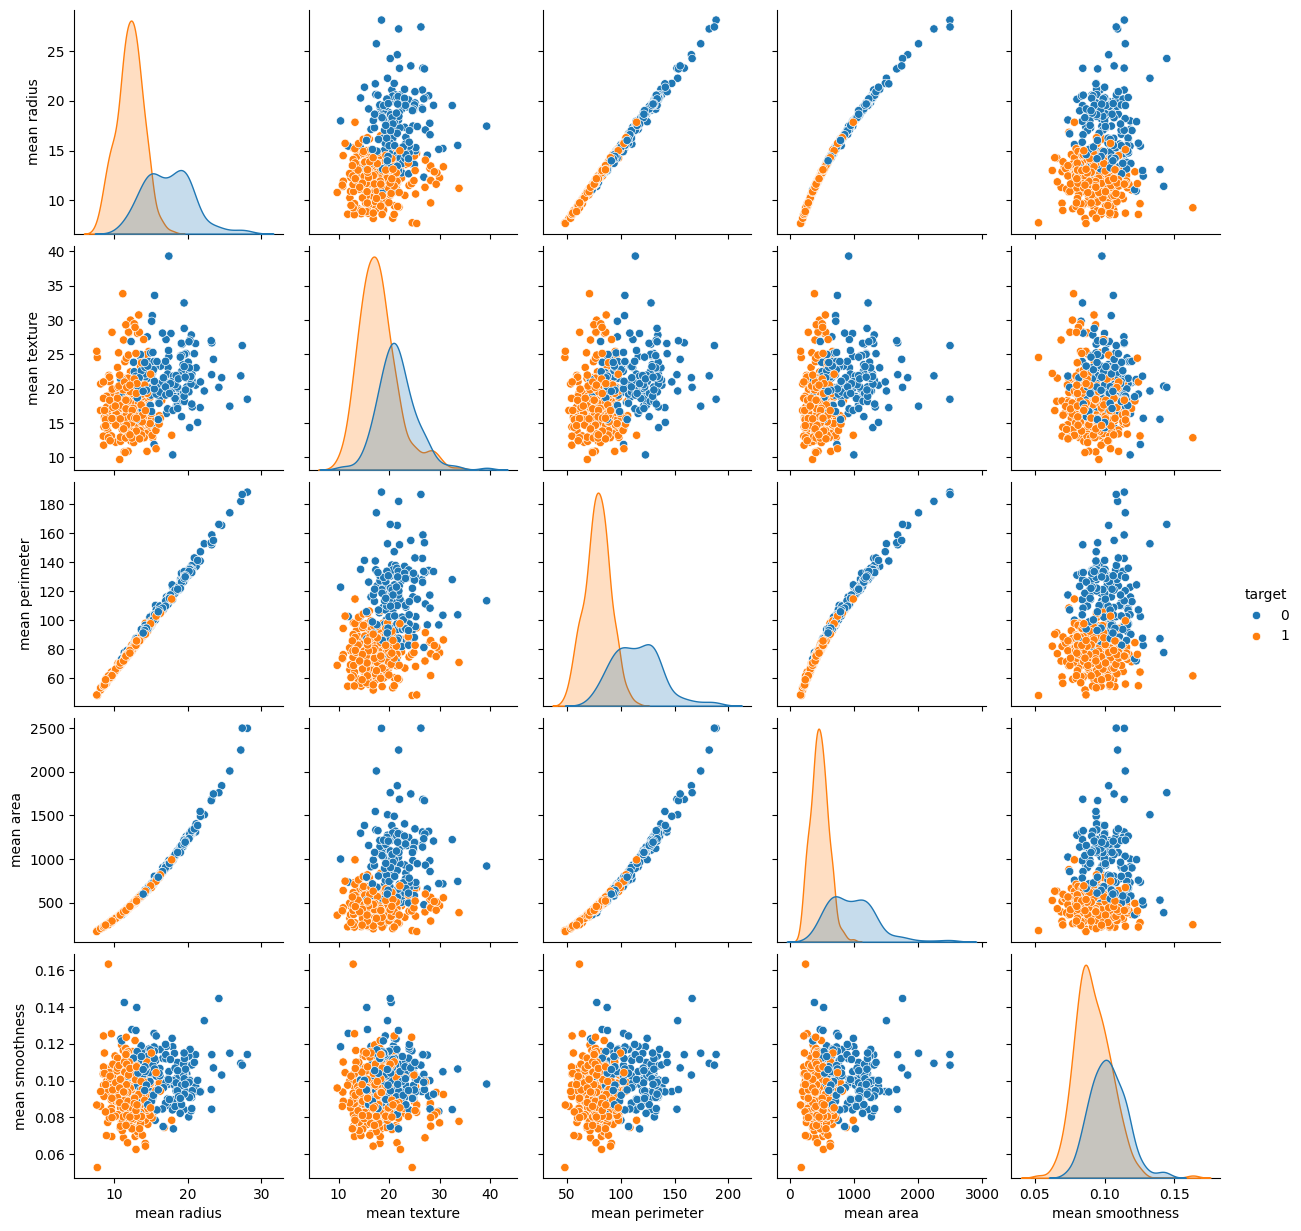

In [44]:

chosen_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

# Plotting features vs target
sns.pairplot(train_data, x_vars=chosen_features, y_vars='target', diag_kind='kde')

sns.pairplot(train_data, x_vars=feature_names, y_vars='target', diag_kind='kde')

# Dataset labels benign vs malignant with 0 and 1s.
df['target'] = df['target'].map({0: 'malignant', 1: 'benign'})

# Plot aach feature (Color based on malignant or benign)
chosen_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
sns.pairplot(train_data, vars=chosen_features, hue='target', diag_kind='kde')

plt.show()

#### c. Please create a binary classification model on your training set to predict which data samples are benign or malignant, and make a confusion matrix to report your results.

The Confusion Matrix report tells us that we have 152 True Positives, 17 False Negatives, 0 False Positives, and 286 True Negatives on the training set. This means that we predicted 17 tumors as benign when they were actually malignant, but 0 cases as malignant when it was actually benign. This produced a Recall of 0.899, and an accuracy of 0.978. 


In [109]:
# Binary One-Hot
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
cutoff = 0.5
y_pred_binary_train = (y_pred_train > cutoff).astype(int)

confusion = confusion_matrix(y_train, y_pred_binary_train)
accuracy = accuracy_score(y_train, y_pred_binary_train)

print("Confusion Matrix Report Train: \n", confusion)
print("Accuracy Report Train:", accuracy)

# print("\nSelected Features):", selected_features)

# Source: Code from precept 6
# https://scikit-learn.org/dev/modules/generated/sklearn.feature_selection.RFE.html

Confusion Matrix Report Train: 
 [[152  17]
 [  0 286]]
Accuracy Report Train: 0.9626373626373627


In [115]:
print("TRAINING:")

# Calculating Recall/Sensitivity
print("Recall:", 152 / (152 + 17))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train))

TRAINING:
Recall: 0.8994082840236687
Accuracy: 0.978021978021978


#### d. For this classification problem, what do you feel is the most appropriate way to measure the “goodness” of the model? Please carefully explain your reasoning!

A "Good" model explains and predicts the data well (minimizes error). In this instance, we are using a confusion matrix because it distinguished between the types of errors, and is especially important considering this is for labeling tumors as malignant or benign. The Recall/Sensitivity is the most appropriate way to measure the "goodness" of the model for this classification problem because this considers the False Negative rate, which is when we predicted two tumors as benign when they were actually malignant. This is most significant because in real life, this would mean telling a patient they do not have breast cancer, when they actually do, causing them to forgo treatment and possibly die. The formula for recall/sensitivity is TP/(TP + FN).

#### e. Please repeat part 1c for each of the following types of classification models, choosing parameters that seem appropriate to give a good model. For each model you make, record the confusion matrix and how well the model performs for the “goodness” metric you decided on in part 1d:

In [71]:
# Classifiers
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
nb = GaussianNB()
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
rf = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

##### i. Logistic Regression


The Confusion Matrix report tells us that we have 160 True Positives, 9 False Negatives, 5 False Positives, and 281 True Negatives on the training set. This means that we predicted 9 tumors as benign when they were actually malignant, and predicted 5 cases as malignant, when it was actually benign. This produced a Recall of 0.956, and an accuracy of 0.969.

On the testing set, we predicted 42 true Positives, 2 False negatives, 1 False Positive, and 70 True Negatives.

In [182]:
def select_features(X_train, y_train, X_test, feature_names, n_features_to_select=6):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    log_reg = LogisticRegression(random_state=42)

    # Feature select train set
    selector = RFE(estimator=log_reg, n_features_to_select=n_features_to_select)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)

    log_reg.fit(X_train_selected, y_train)

    # Store selected
    selected_features_mask = selector.support_
    selected_features = feature_names[selected_features_mask]

    # Feature select test set
    X_test_scaled = scaler.transform(X_test)
    X_test_selected = selector.transform(X_test_scaled)

    final_log_reg = LogisticRegression(random_state=42)

    return log_reg, X_train_selected, X_test_selected, selected_features

# Define models
log_reg_model, X_train_selected, X_test_selected, selected_features = select_features(X_train, y_train, X_test, feature_names)

y_pred_train = log_reg_model.predict(X_train_selected)
confus_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix Report Train: \n", confus_matrix_train)

y_pred_test = log_reg_model.predict(X_test_selected)
confus_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix Report Test: \n", confus_matrix_test)

print("\nSelected Features):", selected_features)

# Source: Code from precept 6
# https://scikit-learn.org/dev/modules/generated/sklearn.feature_selection.RFE.html
# https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html

Confusion Matrix Report Train: 
 [[160   9]
 [  5 281]]
Confusion Matrix Report Test: 
 [[41  2]
 [ 1 70]]

Selected Features): ['mean concave points' 'radius error' 'worst radius' 'worst texture'
 'worst area' 'worst concave points']


In [181]:
print("TRAINING:")

# Calculating Recall/Sensitivity
print("Recall:", 162 / (162 + 7))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train))

print("\nTESTING:")
# Calculating Recall/Sensitivity
print("Recall:", 41 / (41 + 2))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test))


TRAINING:
Recall: 0.9585798816568047
Accuracy: 0.9692307692307692

TESTING:
Recall: 0.9534883720930233
Accuracy: 0.9736842105263158


##### ii. Nearest Neighbors


For KNN, the model performs at 0.89, which is less than the Logistic Regression. When changing the number of features chosen, ranging from 10 to 3, this did not affect the confusion matrix. 

In [150]:
# KNN
def select_features_knn(X_train, y_train, X_test, feature_names, k=6):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    vt = VarianceThreshold(threshold=0.1)
    X_train_vt = vt.fit_transform(X_train_scaled)

    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_vt, y_train)

    # Store selected
    selected_features_mask = selector.get_support()
    selected_features = feature_names[vt.get_support()][selected_features_mask]

    knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
    knn.fit(X_train_selected, y_train)  

    # Feature select test set
    X_test_scaled = scaler.transform(X_test)
    X_test_vt = vt.fit_transform(X_test_scaled)
    X_test_selected = selector.transform(X_test_vt)

    return knn, X_train_selected, X_test_selected, selected_features

# Define models
knn_model, X_train_selected_knn, X_test_selected_knn, selected_features  = select_features_knn(X_train, y_train, X_test, feature_names)

y_pred_train_knn =knn_model.predict(X_train_selected_knn)
confus_matrix_train_knn = confusion_matrix(y_train, y_pred_train_knn)
print("Confusion Matrix Report Train KNN: \n", confus_matrix_train_knn)

y_pred_test_knn =knn_model.predict(X_test_selected_knn)
confus_matrix_test_knn = confusion_matrix(y_test, y_pred_test_knn)
print("Confusion Matrix Report Test KNN: \n", confus_matrix_test_knn)

print("\nSelected Features KNN:", selected_features)

# Source: Code From Precept 6

Confusion Matrix Report Train KNN: 
 [[154  15]
 [  5 281]]
Confusion Matrix Report Test KNN: 
 [[41  2]
 [ 2 69]]

Selected Features KNN: ['mean perimeter' 'mean concave points' 'worst radius' 'worst perimeter'
 'worst area' 'worst concave points']


In [152]:
print("TRAINING KNN:")
# Calculating Recall/Sensitivity
print("Recall:", 151 / (151 + 18))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train_knn))

print("\nTESTING KNN:")
# Calculating Recall/Sensitivity
print("Recall:", 39 / (39 + 4))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_knn))

TRAINING KNN:
Recall: 0.893491124260355
Accuracy: 0.9560439560439561

TESTING KNN:
Recall: 0.9069767441860465
Accuracy: 0.9649122807017544


##### iii. Naive Bayes


For NB, the model performs at 0.911, which is more than KNN but less than the Logistic Regression, at 0.95, in part c. When changing the number of features chosen, ranging from 10 to 3, this slightly affected the accuracy and recall, with 6 features chosen.

In [153]:
# Naive Bayes with SelectKBest
def select_features_nb(X_train, y_train, X_test, feature_names, k=6):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    vt = VarianceThreshold(threshold=0.1)
    X_train_vt = vt.fit_transform(X_train_scaled)

    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_vt, y_train)

    # Store selected
    selected_features_mask = selector.get_support()
    selected_features = feature_names[vt.get_support()][selected_features_mask]

    nb = GaussianNB()
    nb.fit(X_train_selected, y_train)  

    # Feature select test set
    X_test_scaled = scaler.transform(X_test)
    X_test_vt = vt.fit_transform(X_test_scaled)
    X_test_selected = selector.transform(X_test_vt)

    return nb, X_train_selected, X_test_selected, selected_features

# Define models
nb_model, X_train_selected_nb, X_test_selected_nb, selected_features  = select_features_nb(X_train, y_train, X_test, feature_names)

y_pred_train_nb =nb_model.predict(X_train_selected_nb)
confus_matrix_train_nb = confusion_matrix(y_train, y_pred_train_nb)
print("Confusion Matrix Report Train NB: \n", confus_matrix_train_nb)

y_pred_test_nb =nb_model.predict(X_test_selected_nb)
confus_matrix_test_nb = confusion_matrix(y_test, y_pred_test_nb)
print("Confusion Matrix Report Test NB: \n", confus_matrix_test_nb)

print("\nSelected Features NB:", selected_features)

# Source: Code from precept 6

Confusion Matrix Report Train NB: 
 [[154  15]
 [ 12 274]]
Confusion Matrix Report Test NB: 
 [[40  3]
 [ 3 68]]

Selected Features NB: ['mean perimeter' 'mean concave points' 'worst radius' 'worst perimeter'
 'worst area' 'worst concave points']


In [154]:
print("TRAINING NB:")
# Calculating Recall/Sensitivity
print("Recall:", 155 / (155 + 15))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train_knn))

print("\nTESTING NB:")
# Calculating Recall/Sensitivity
print("Recall:", 40 / (40 + 3))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_knn))

TRAINING NB:
Recall: 0.9117647058823529
Accuracy: 0.9560439560439561

TESTING NB:
Recall: 0.9302325581395349
Accuracy: 0.9649122807017544


##### iv. Support Vector Machines

For NB, the model performs at 0.959, which is more than KNN and Naive Bates but about on par with Logistic Regression, at 0.95. When changing the number of features chosen, ranging from 10 to 3, this did not significantly affect the accuracy and recall, with 5 features chosen.

In [201]:
# SVM with RFE
def select_features_svm(X_train, y_train, X_test, feature_names, n_features_to_select=5):
    scaler = StandardScaler()
    svm = SVC(kernel='linear', probability=True, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)

    # Feature select train set
    selector = RFE(estimator=svm, n_features_to_select=n_features_to_select)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)

    svm.fit(X_train_selected, y_train)

    # Store selected
    selected_features_mask = selector.support_
    selected_features = feature_names[selected_features_mask]

    # Feature select test set
    X_test_scaled = scaler.transform(X_test)
    X_test_selected = selector.transform(X_test_scaled)

    return svm, X_train_selected, X_test_selected, selected_features

# Define models
svm_model, X_train_selected_svm, X_test_selected_svm, selected_features  = select_features_svm(X_train, y_train, X_test, feature_names)

y_pred_train_svm =svm_model.predict(X_train_selected_svm)
confus_matrix_train_svm = confusion_matrix(y_train, y_pred_train_svm)
print("Confusion Matrix Report Train SVM: \n", confus_matrix_train_svm)

y_pred_test_svm =svm_model.predict(X_test_selected_svm)
confus_matrix_test_svm = confusion_matrix(y_test, y_pred_test_svm)
print("Confusion Matrix Report Test SVM: \n", confus_matrix_test_svm)

print("\nSelected Features SVM:", selected_features)



Confusion Matrix Report Train SVM: 
 [[160   9]
 [  7 279]]
Confusion Matrix Report Test SVM: 
 [[40  3]
 [ 1 70]]

Selected Features SVM: ['mean concavity' 'mean concave points' 'worst radius' 'worst texture'
 'worst area']


In [198]:
print("TRAINING SVM:")
# Calculating Recall/Sensitivity
print("Recall:", 162 / (162 + 7))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train_svm))

print("\nTESTING SVM:")
# Calculating Recall/Sensitivity
print("Recall:", 41 / (41 + 2))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_svm))

TRAINING SVM:
Recall: 0.9585798816568047
Accuracy: 0.9648351648351648

TESTING SVM:
Recall: 0.9534883720930233
Accuracy: 0.9649122807017544


##### v. Decision Trees


The Decision Tree had a recall of 1.0 for the training data, but 0.93 for the testing data, which is lower than both Logistic Regression and Support Vector Machines. This model also used 5 features at a threshold of 0.1.

In [174]:
# 5. Decision Tree with built-in feature importance
def select_features_dt(X_train, y_train, X_test, feature_names, threshold=0.01):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    importances = dt.feature_importances_
    selected_features_mask = importances > threshold
    selected_features =feature_names[selected_features_mask]


    X_train_selected = X_train[:, selected_features_mask]
    X_test_selected = X_test[:, selected_features_mask]

    final_dt = DecisionTreeClassifier(random_state=42)
    final_dt.fit(X_train_selected, y_train)

    return final_dt, X_train_selected, X_test_selected, selected_features

dt_model, X_train_selected_dt, X_test_selected_dt, selected_features_dt = select_features_dt(X_train, y_train, X_test, feature_names)

y_pred_train_dt = dt_model.predict(X_train_selected_dt)
confus_matrix_train_dt = confusion_matrix(y_train, y_pred_train_dt)
print("Confusion Matrix Report Train DT: \n", confus_matrix_train_dt)

# Predict and evaluate on testing data
y_pred_test_dt = dt_model.predict(X_test_selected_dt)
confus_matrix_test_dt = confusion_matrix(y_test, y_pred_test_dt)
print("Confusion Matrix Report Test DT: \n", confus_matrix_test_dt)


print("\nSelected Features DT:", selected_features_dt)



# Source: Precept 6


Confusion Matrix Report Train DT: 
 [[169   0]
 [  0 286]]
Confusion Matrix Report Test DT: 
 [[40  3]
 [ 4 67]]

Selected Features DT: ['mean texture' 'mean concave points' 'area error' 'concave points error'
 'fractal dimension error' 'worst radius' 'worst texture'
 'worst perimeter' 'worst concave points']


In [158]:
print("TRAINING DT:")
# Calculating Recall/Sensitivity
print("Recall:", 169 / (169 + 0))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train_dt))

print("\nTESTING DT:")
# Calculating Recall/Sensitivity
print("Recall:", 40 / (40 + 3))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_dt))

TRAINING DT:
Recall: 1.0
Accuracy: 1.0

TESTING DT:
Recall: 0.9302325581395349
Accuracy: 0.9385964912280702


##### vi. Random Forests

The Random Forests had a recall of 1.0 for the training data, but 0.93 for the testing data, which is lower than both Logistic Regression and Support Vector Machines. I alternated between a threshold of 0.1 to 0.5, which produced no noticeable difference in the table or recall. We went with a threshold of 0.5 because at 0.1, the tree used 19 features, which was a majority of traits. This model also used 7 features at a threshold of 0.5.

In [159]:

# 6. Random Forest with built-in feature importance
def select_features_rf(X_train, y_train, X_test, feature_names, threshold=0.05):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_

    selected_features_mask = importances > threshold
    selected_features = feature_names[selected_features_mask]

    X_train_selected = X_train[:, selected_features_mask]
    X_test_selected = X_test[:, selected_features_mask]    
    
    final_rf = RandomForestClassifier(random_state=42)
    final_rf.fit(X_train_selected, y_train)

    return final_rf, X_train_selected, X_test_selected, selected_features


rf_model, X_train_selected_rf, X_test_selected_rf, selected_features_rf = select_features_rf(X_train, y_train, X_test, feature_names)

y_pred_train_rf = rf_model.predict(X_train_selected_rf)
confus_matrix_train_rf = confusion_matrix(y_train, y_pred_train_rf)
print("Confusion Matrix Report Train RF: \n", confus_matrix_train_rf)

# Predict and evaluate on testing data
y_pred_test_rf = rf_model.predict(X_test_selected_rf)
confus_matrix_test_rf = confusion_matrix(y_test, y_pred_test_rf)
print("Confusion Matrix Report Test RF: \n", confus_matrix_test_rf)


print("\nSelected Features RF:", selected_features_rf)

#Source: Precept 6

Confusion Matrix Report Train RF: 
 [[169   0]
 [  0 286]]
Confusion Matrix Report Test RF: 
 [[40  3]
 [ 2 69]]

Selected Features RF: ['mean perimeter' 'mean concavity' 'mean concave points' 'worst radius'
 'worst perimeter' 'worst area' 'worst concave points']


In [160]:
print("TRAINING RF:")
# Calculating Recall/Sensitivity
print("Recall:", 169 / (169 + 0))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train_rf))

print("\nTESTING RF:")
# Calculating Recall/Sensitivity
print("Recall:", 40 / (40 + 3))

# Calculating Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))

TRAINING RF:
Recall: 1.0
Accuracy: 1.0

TESTING RF:
Recall: 0.9302325581395349
Accuracy: 0.956140350877193


#### f. Which model performed the best on the training data, and how well did they perform in general?

Training Recall:

Logistic Regression: 0.9586

Nearest Neighbors: 0.8935

Naive Bayes: 0.9118

Support Vector Machine: 0.9586

Decision Tree: 1.0

Random Forests: 1.0


Accuracy:

Nearest Neighbors: 0.9649

Logistic Regression: 0.969

Naive Bayes: 0.9649

Support Vector Machine: 0.9649

Decision Tree: 0.9386

Random Forests: 0.9561

The Decision Tree and Random Forests performed the best on the testing data because the branches of the tree were created based on the training data itself. Aside from these, Logistic Regression and Support Vector Machines outperformed the others, with a Recall of about 0.95. This is interesting because the simpler model, logistic regression, seemingly performed as well as the SVM. It is worth noting that the Logistic Regression did use 6 features, while SVM  used 5. In terms of accuracy, logistic regression was also the most accurate, with KNN, Naive Bayes, and SVM being about the same.



#### g. Which model performed the best on the testing data, and how well did they perform in general?

Testing Recall:
Logistic Regression: 0.9535
Nearest Neighbors: 0.9070
Naive Bayes: 0.9302
Support Vector Machine: 0.9535
Decision Tree: 0.9302
Random Forests: 0.9302

Accuracy:
Nearest Neighbors: 0.9649
Logistic Regression: 0.9737
Naive Bayes: 0.0.9649
Support Vector Machine: 0.9649
Decision Tree: 0.9386
Random Forests: 0.9561

The Logistic regression and support vector machine again performed the best, with the highest recalls of 0.954 and 0.954 respectively. Again, the accuracy of logistic regression was the highest. The Nearest Neighbors performed the worst on recall, however the accuracy was above both decision trees and random forests. Logistic Regression did use the most features, which could explain this performance.


## Q2: Explaining your model

### a. Please explain which features are the most important in each of your models in part 1e? Is this similar across all models? How does this agree with your expectations from part 1b? Please carefully explain your reasoning

In Logistic Regression, worst radius, worst texture, worst area, and worst concave points were most important. For the feature selection method, we used Recursive Feature Elimination (RFE), evaluates the models coefficients and determines importance of each feature. 
In K-Nearest Neighbors, mean perimeter, worst radius, worst perimeter, worst area, and worst concave points were most important. We used SelectKBest to reduce the number of features to the specific number, 6.This makes the model less prone to overfitting.
In Naive Bayes, mean perimeter, mean concave points, worst radius, worst perimeters, worst area, and worst concave points were most important. We used SelectKBest for the same reasons mentioned above, with 6 features.
In Support vector Machines (SVM), mean concavity, mean concave points, worst radius, worst texture, and worst area. In SVM, we used RFE as well.
In Decision trees, mean concavity, mean concave points, worst radius, worst texture, and worst area are most important. In Random Forests, mean perimeter, mean concave points, worst radius, worst perimeter, worst area, worst concave points are most important. For both Decision Trees and Random Forests, we used the built-in feature importance to evaluate the importance of each feature, with a threshold of 0.5 for RF and 0.1 for Decision Trees.

I found this by calculating the selected features using the built-in scikit learn tools, and features with the importance above a specified threshold for random forests and decision trees. I stored a boolean array indicating what features were selected by the selector tool, then identified those features and passed them onto the final version of the model.

Across all models, worst radius, worst texture, worst area, and worst concave points were most important. I expected that mean radius, mean perimeter, and mean area would be most important, which was similar traits but lacking 'worst'. 

### b. Of all of the models in 1e, which was the most explainable? Why?

K-nearest Neighbors and Support Vector Machines are very complex, which could be beneficial if the accuracy and recall were the highest, which they were not. Logistic Regression is simple to understand, and performed the best, however, and even when the number of features was decreased to 4, the recall and accuracy remained high at 0.9586. The Decision Trees allow for visual hierarchy and ranking to see which traits are most important, however, this comes at the cost of Recall, which could be detrimental to a patient's life. Thus, Logistic Regression was the most explainable. 

### c. How might this information be useful in communicating to doctors performing screenings for cancer based on these images?

This information would be helpful because doctors performing screenings could consider worst radius, worst texture, worst area, and worst concave points most heavily when identifying cancer, and additionally could use a tool like the Logistic Regression model on larger sets of data to provide for classification that is simple to understand yet has high accuracy and the lowest chance of misdiagnosing a patient with cancer as not having cancer.

## Q3: Varying the Decision Threshold (10%)

### a. For one of the models above that predicts the probabilities to perform the classification (i.e. Naive Bayes, Logistic Regression, Decision Trees, Random Forests), please construct/plot the Receiver Operating Characteristic (ROC) curve to show how well the model performs with across various choices of thresholds.

Optimal Threshold based on Youden's J: 0.6895392811934864


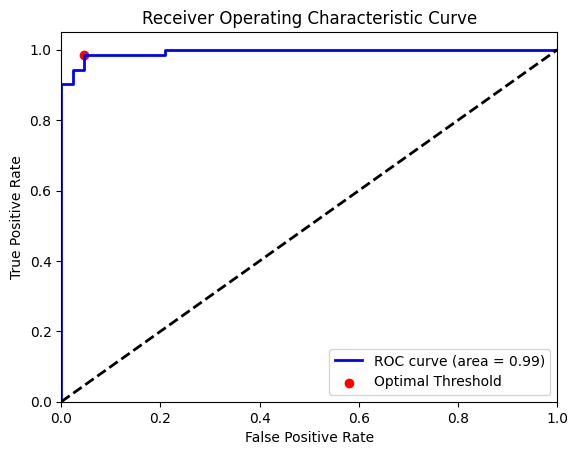

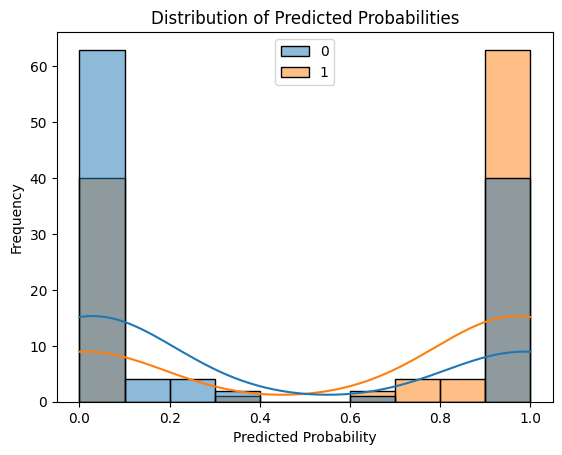

In [210]:
# SVM Model ROC
y_predicted_prob = svm_model.predict_proba(X_test_selected_svm)
# print(y_predicted_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Youden's J statistic
j_scores = tpr - fpr 
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold based on Youden's J:", optimal_threshold)


# Draw  ROC curves
plt.figure()
colors = cycle(['blue'])
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Optimal Threshold')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the distribution of predicted probabilities
sns.histplot(y_predicted_prob, bins=10, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic

### b. What is the area under this ROC curve? What does this tell us about our model?

The area under this ROC curve is 0.99. This tells use that the model has excellent performance, because it identifies 99% of the true positives, which keeping a low false posiitve rate. The threshold is low, meaning there is a higher likelihood of identifying positive cases, or patients with cancer. This is very helpful in our case, because this means there is higher recall.  

### c. Extra Credit: What is the optimal choice of threshold for this model to optimize your “goodness” measure in part 1d? How did you find this?

The optimal threshold is below 0.1, meaning that the model has a higher likelihood of classifying cases as positive. This was found using the Youden's index, which is used to find the classification threshold. The statistic is defined as sensitivity + specificity - 1 which equals TPR - FPR. We then found the index of the largest value in the array, then we get the value corresponding to that index and print. 


// Source: https://www.sciencedirect.com/topics/medicine-and-dentistry/youden-index